In [1]:
from heeps.util.img_processing import resize_cube, resize_img, crop_img
from scipy.interpolate import interp2d,RectBivariateSpline, griddata
from heeps.pupil.create_petal import create_petal
import numpy
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
def zoomWithMissingData(data, newSize,
                        method='linear',
                        non_valid_value=numpy.nan):
    '''
    Zoom 2-dimensional or 3D arrays using griddata interpolation.
    This allows interpolation over unstructured data, e.g. interpolating values
    inside a pupil but excluding everything outside.
    See also DM.CustomShapes.

    Note that it can be time consuming, particularly on 3D data

    Parameters
    ----------
    data : ndArray
        2d or 3d array. If 3d array, interpolate by slices of the first dim.
    newSize : tuple
        2 value for the new array (or new slices) size.
    method: str
        'linear', 'cubic', 'nearest'
    non_valid_value: float
        typically, NaN or 0. value in the array that are not valid for the
        interpolation.

    Returns
    -------
    arr : ndarray
        of dimension (newSize[0], newSize[1]) or
        (data.shape[0], newSize[0], newSize[1])
    '''
    if len(data.shape) == 3:
        arr = data[0, :, :]
    else:
        assert len(data.shape) == 2
        arr = data

    Nx = arr.shape[0]
    Ny = arr.shape[1]
    coordX = (numpy.arange(Nx) - Nx / 2. + 0.5) / (Nx / 2.)
    coordY = (numpy.arange(Ny) - Ny / 2. + 0.5) / (Ny / 2.)
    Nx = newSize[0]
    Ny = newSize[1]
    ncoordX = (numpy.arange(Nx) - Nx / 2. + 0.5) / (Nx / 2.)
    ncoordY = (numpy.arange(Ny) - Ny / 2. + 0.5) / (Ny / 2.)

    x, y = numpy.meshgrid(coordX, coordY)
    xnew, ynew = numpy.meshgrid(ncoordX, ncoordY)

    if len(data.shape) == 2:
        idx = ~(arr == non_valid_value)
        znew = griddata((x[idx], y[idx]), arr[idx], (xnew, ynew),
                        method=method)
        return znew
    elif len(data.shape) == 3:
        narr = numpy.zeros((data.shape[0], newSize[0], newSize[1]))
        for i in range(data.shape[0]):
            arr = data[i, :, :]
            idx = ~(arr == non_valid_value)
            znew = griddata((x[idx], y[idx]), arr[idx], (xnew, ynew),
                            method=method)
            narr[i, :, :] = znew
        return narr
#--------------------------------------------------#

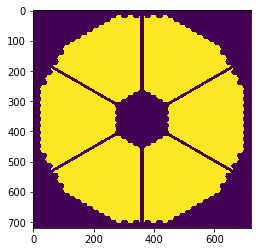

In [3]:
nimg = 720
mask = np.float32(fits.getdata('/Users/cdelacroix/dox/METIS/METIS_HCI_HEEPS_simulations/scao_petal_piston/Telescope_Pupil.fits'))
mask = crop_img(mask, nimg)
mask = np.rot90(mask)
plt.imshow(mask)

data piston (nm) = 1801.4716
data rms (nm) = 116.93555


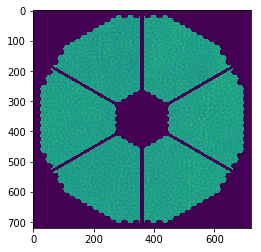

In [4]:
#data = np.random.randn(nimg, nimg)*200 + 100
data = np.float32(fits.getdata('/Users/cdelacroix/dox/METIS/METIS_HCI_HEEPS_simulations/scao_petal_piston/Residual_phase_screen_2101ms.fits'))
data = crop_img(data, nimg)
data = np.rot90(data) * 1e3        # rotate, convert to nanometers
data[mask==0] = 0
print('data piston (nm) = %s\ndata rms (nm) = %s'%(np.mean(data[mask!=0]), np.std(data[mask!=0])))
plt.imshow(data)

### remove piston

In [5]:
data -= np.mean(data[mask!=0])
data[mask==0] = 0
print('data piston (nm) = %s\ndata rms (nm) = %s'%(np.mean(data[mask!=0]), np.std(data[mask!=0])))

data piston (nm) = 0.0002272726
data rms (nm) = 116.93555


### petal piston

petal piston (nm) = [ 2.285486    0.7971825  -2.1207469   0.56565714 -3.055651    1.5282139 ]
petal rms (nm) = [38.729744 36.3713   37.083916 37.330242 38.70254  37.560745]


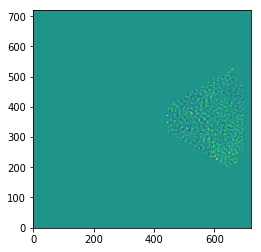

In [6]:
npetals = 6
petals = np.float32([create_petal(x, npetals, nimg) for x in range(npetals)])
data_petals = data*petals
plt.imshow(data_petals[0], origin=True)
print('petal piston (nm) = %s\npetal rms (nm) = %s'%(np.mean(data_petals, (1,2)), np.std(data_petals, (1,2))))

# Resize with skimage (currently in HEEPS)

In [7]:
npupil = 285
petals_res = np.float32([create_petal(x, npetals, npupil) for x in range(npetals)])
data_res = resize_img(data, npupil)
print('petal pistons (nm) = %s\npetal rms (nm) = %s'%(np.mean(data_res*petals_res, (1,2)), np.std(data_res*petals_res, (1,2))))
data_res.shape

petal pistons (nm) = [ 2.2831342  0.7933628 -2.1226683  0.5725751 -3.0487597  1.5336455]
petal rms (nm) = [32.29694  29.902475 30.578646 30.466803 32.342136 31.286016]


(285, 285)

### resized pupil

duration (s) = 0.10082006454467773


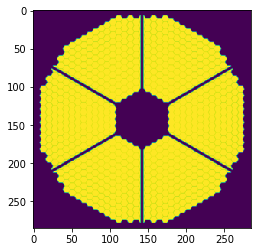

In [8]:
t0 = time.time()
pupil = fits.getdata('/Users/cdelacroix/INSTRUMENTS/METIS/heeps_analysis/input_files/pupil/ELT_fullM1.fits')
pupil_res = resize_img(pupil, npupil)
plt.imshow(pupil_res)
print('duration (s) = %s'%(time.time() - t0))

# Resize with scipy (Gilles' alternative method)

In [9]:
data_gox = zoomWithMissingData(data, [npupil,npupil], method='nearest', non_valid_value=np.nan)
print('petal pistons (nm) = %s\npetal rms (nm) = %s'%(np.mean(data_gox*petals_res, (1,2)), np.std(data_gox*petals_res, (1,2))))
data_gox.shape

petal pistons (nm) = [ 2.2580895   0.854473   -2.1226943   0.60943216 -3.0592282   1.5701221 ]
petal rms (nm) = [38.692772 36.63309  37.47547  37.19889  38.93918  37.81144 ]


(285, 285)

### resized pupil

duration (s) = 5.58513617515564


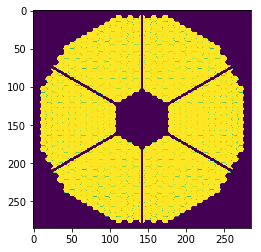

In [10]:
t0 = time.time()
pupil_gox = zoomWithMissingData(pupil, [npupil,npupil], method='nearest', non_valid_value=np.nan)
plt.imshow(pupil_gox)
print('duration (s) = %s'%(time.time() - t0))